In [1]:
%%capture
%matplotlib inline
%time

# Had to install this funcy dependency manually, there was a bug in cadCAD, where the dependency wasn't loaded
# import sys
# !{sys.executable} -m pip install --user funcy

# instal line profiler, for optimizing notebook
# !pip install --user line_profiler
# !pip install --user Pillow

import os.path
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import importlib
import policies
import config
import state_updates
import utils
from numpy.random import rand

importlib.reload(config)
importlib.reload(policies)
importlib.reload(state_updates)
importlib.reload(utils)

initial_conditions, disaster_ideal, rarity, market_settings = config.initial_conditions, config.disaster_ideal, config.rarity, config.market_settings

In [2]:
# height of each graph (for plotting)
plt_row_height = 7
plt_width = 20

def player_active():
    awake_likelihood = 0.6  # 60% probability of player being awake
    active_likelihood = 0.05 # 3 hours of play in 7 day week
    return rand() < (awake_likelihood*active_likelihood)

params = {
    'duration': [60], # duration of timestep (in minutes)
    'player_active': [player_active],
    # reserve_ratio [0.5, 0.6, 0.7.. 0.9]
    # priceMultiplier [5, 10, 15, 20]
    # virtualBalace [1 .. 100]
    # virtualSupply [100..100000 ? ]
    'payMultiplier': [0.1]
    
    # =>>>> total clovers in end created
    # =>>>> price of token (wanting it to be high)
    #'payMultiplier': [0.2]
}

previousRuns = (0) * 24
days = 5
timesteps_per_run = int(24 * days)
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(timesteps_per_run),
    'N': monte_carlo_runs,
    'M': params
})
simulation_parameters

[{'N': 1,
  'T': range(0, 120),
  'M': {'duration': 60,
   'player_active': <function __main__.player_active()>,
   'payMultiplier': 0.1}}]

In [3]:
initialized_conditions = initial_conditions
# initialized_conditions = disaster_ideal
        

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    {
        'policies': {},
        'variables': {
            's': state_updates.initialize
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'participantPool': policies.participant_pool_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_participant_pool
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'minerPolicy': policies.miner_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state_miner_policy
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'playerPolicy': policies.player_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'marketActivityPolicy': policies.market_activity_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            's': state_updates.update_state
        }
    },
    {
        'policies': {},
        'variables':{
            's': state_updates.save_file
        }
    }
    #     speculators # folks speculating on clover coin price
]

In [4]:
from tabulate import tabulate
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(multi_proc_ctx, configs=configs)

In [5]:
import networkx as nx

g = nx.DiGraph()
g.add_node('foo')
len(g.nodes())

1

In [6]:
i = 0
verbose = False
results = []
for raw_result, tensor_field in run.execute():
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results.append({})
    results[i]['result'] = raw_result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1

multi_proc: [<cadCAD.configuration.Configuration object at 0x10b4ee438>]
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 0
    clovers 0
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 1
    clovers 4
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 2
    clovers 6
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 3
    clovers 10
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 4
    clovers 12
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 5
    clovers 17
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
 

    timestep 58
    clovers 285
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 59
    clovers 295
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 60
    clovers 315
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 61
    clovers 321
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 62
    clovers 329
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 63
    clovers 331
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 64
    clovers 333
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 65
    clovers

    timestep 117
    clovers 584
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 118
    clovers 588
Paramset: {'duration': 60, 'player_active': <function player_active at 0x11d2e2bf8>, 'payMultiplier': 0.1}
    timestep 119
    clovers 590


In [7]:
%%time
# {'s': {'bc-balance': 40, 'bc-totalSupply': 30297.222282697643, 'symmetries': {'hasSymmetry': 0, 'rotSym': 0, 'y0Sym': 0, 'x0Sym': 0, 'xySym': 0, 'xnySym': 0}, 'network': <networkx.classes.digraph.DiGraph object at 0x7feb94401eb8>, 'players': [61728968314424, 293889188073290, 226408724277593, 472925374878931, 638758537652366, 344097444779201, 129303744057255, 316855034068104, 215183806154351, 232027941686814], 'miners': [895282972085115], 'bank': 325998228332377, 'clovers': []}}
def to_df(raw_result):
    def flatten_cols(row):
        timestep = row['timestep']
        row['timestep'] += previousRuns
        substep = row['substep']
        run = row['run']
        s = row['s']
        new_cols = {}
        miners = utils.get_nodes_by_type(s, 'miner')
        players = utils.get_nodes_by_type(s, 'player')
        clovers = utils.get_nodes_by_type(s, 'clover')
        sample_clover = {'hasSymmetry': True}
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            sample_clover[key] = False
        for key in s['symmetries'].keys():
            if key == 'hasSymmetry': continue
            clover = dict(sample_clover)
            clover[key] = True
            reward = utils.getCloverReward(s['symmetries'], clover, market_settings)
            new_cols['reward-' + key] = reward
            cashout = utils.calculateCashout(s, market_settings, reward)
            if (cashout == 0):
                cashout = .001311
            new_cols['reward-eth-' + key] = cashout
            
        # timestep stats
        new_cols['cloversKept'] = s['timestepStats']['cloversKept']
        new_cols['cloversReleased'] = s['timestepStats']['cloversReleased']
        new_cols['cloversTraded'] = s['timestepStats']['cloversTraded']
        new_cols['cloversBoughtFromBank'] = s['timestepStats']['cloversBoughtFromBank']
        new_cols['cloversListedByPlayers'] = s['timestepStats']['cloversListedByPlayers']

        new_cols['cost-to-mine'] = market_settings['register_clover_cost_in_eth']
        new_cols['cost-to-mine-usd'] = market_settings['register_clover_cost_in_eth'] * 300
        new_cols['miners'] = len(miners)
        new_cols['players'] = len(players)
        new_cols['clovers'] = len(clovers)
        new_cols.update(s['symmetries'])
        price = utils.calculateCurrentPrice(s, market_settings)
        if (price == 0):
#             _s = raw_results[(row['timestep'] - 1) * len(partial_state_update_blocks)]
#             price = utils.calculateCurrentPrice(_s, market_settings)
            price = 0.000803
        new_cols['coin-price'] = price
        new_cols['coin-price-usd'] = new_cols['coin-price'] * 300
        # new_cols['playerClovers'] = new_cols['clovers'] = new_cols['bankClovers']
        # for clover_attr in ['hasSymmetry', 'y0Sym', 'x0Sym', 'xySym', 'xnySym', 'rotSym', 'pretty']:
        #     new_cols['net_' + clover_attr] = len([c for c in clovers if g.nodes[c][clover_attr]])

        res = {**row, **s, **new_cols}
        res.pop('network')
#         res.pop('hasSymmetry')
        res.pop('previous-timesteps')
        res.pop('symmetries')
        res.pop('bank')
#         res.pop('miners')
#         res.pop('players')
#         res.pop('clovers')
        res.pop('run')
        res.pop('s')
        return res

    print(type(raw_result))
    df = pd.DataFrame(map(flatten_cols, raw_result))
    return df

full_df = to_df(results[0]['result'])
# adding new useful columns for graphing

full_df['market-cap'] = full_df['coin-price'] * full_df['bc-totalSupply'] * 300

full_df

<class 'list'>
CPU times: user 38.7 ms, sys: 4.94 ms, total: 43.6 ms
Wall time: 46.4 ms


,substep,timestep,bc-balance,bc-totalSupply,numBankClovers,numPlayerClovers,timestepStats,clovers,players,miners,...,cost-to-mine-usd,hasSymmetry,rotSym,y0Sym,x0Sym,xySym,xnySym,coin-price,coin-price-usd,market-cap
0,0,0,0.000000,0.000000,0,0,"{'cloversKept': 0, 'cloversReleased': 0, 'clov...",0,0,0,...,1.2,1130,60,121,120,411,467,0.000803,0.240900,0.000000
1,1,1,32.000000,14275.258669,0,0,"{'cloversKept': 0, 'cloversReleased': 0, 'clov...",0,20,1,...,1.2,1130,60,121,120,411,467,0.001706,0.511927,7307.889678
2,2,1,32.000000,14275.258669,0,0,"{'cloversKept': 0, 'cloversReleased': 0, 'clov...",0,20,1,...,1.2,1130,60,121,120,411,467,0.001706,0.511927,7307.889678
3,3,1,31.973273,14275.258669,4,0,"{'cloversKept': 0, 'cloversReleased': 4, 'clov...",4,20,1,...,1.2,1134,61,123,121,411,467,0.001706,0.511716,7304.884759
4,4,1,31.973273,14275.258669,4,0,"{'cloversKept': 0, 'cloversReleased': 4, 'clov...",4,20,1,...,1.2,1134,61,123,121,411,467,0.001706,0.511716,7304.884759
5,5,1,31.973273,14275.258669,4,0,"{'cloversKept': 0, 'cloversReleased': 4, 'clov...",4,20,1,...,1.2,1134,61,123,121,411,467,0.001706,0.511716,7304.884759
6,6,1,31.973273,14275.258669,4,0,"{'cloversKept': 0, 'cloversReleased': 4, 'clov...",4,20,1,...,1.2,1134,61,123,121,411,467,0.001706,0.511716,7304.884759
7,1,2,31.973273,14275.258669,4,0,"{'cloversKept': 0, 'cloversReleased': 0, 'clov...",4,20,1,...,1.2,1134,61,123,121,411,467,0.001706,0.511716,7304.884759
8,2,2,31.973273,14275.258669,4,0,"{'cloversKept': 0, 'cloversReleased': 0, 'clov...",4,20,1,...,1.2,1134,61,123,121,411,467,0.001706,0.511716,7304.884759
9,3,2,31.957492,14275.258669,6,0,"{'cloversKept': 0, 'cloversReleased': 2, 'clov...",6,20,1,...,1.2,1136,62,124,121,411,467,0.001705,0.511592,7303.110518


In [8]:
#for result in results:
#    params = result['simulation_parameters']['M']
#    g = utils.getNetwork(params)
#
#    # print(len(g.nodes))
#    print("clovers", len([node for node in g.nodes if g.nodes[node]['type']== 'clover' ]))
#    print("miners", len([node for node in g.nodes if g.nodes[node]['type']== 'miner' ]))
#    print("players", len([node for node in g.nodes if g.nodes[node]['type']== 'player' ]))
#    def make_clover(cloverId):
#        clover = g.node[cloverId]
#        clover['_id'] = cloverId
#        return clover
#    
#    clovers_ids = result['result'][-1]['s']['clovers']
#    clover_df = pd.DataFrame(map(make_clover, clovers_ids))
#    pd.set_option('display.max_rows', 50)
#    # pd.concat([clover_df.head(10), clover_df.tail(10)])
#    clover_df

In [9]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df = full_df[full_df['substep'] == len(partial_state_update_blocks)]
df_with_0 = full_df[full_df['substep'] == 0].append(full_df[full_df['substep'] == len(partial_state_update_blocks)]) # after player policy
#df_with_0

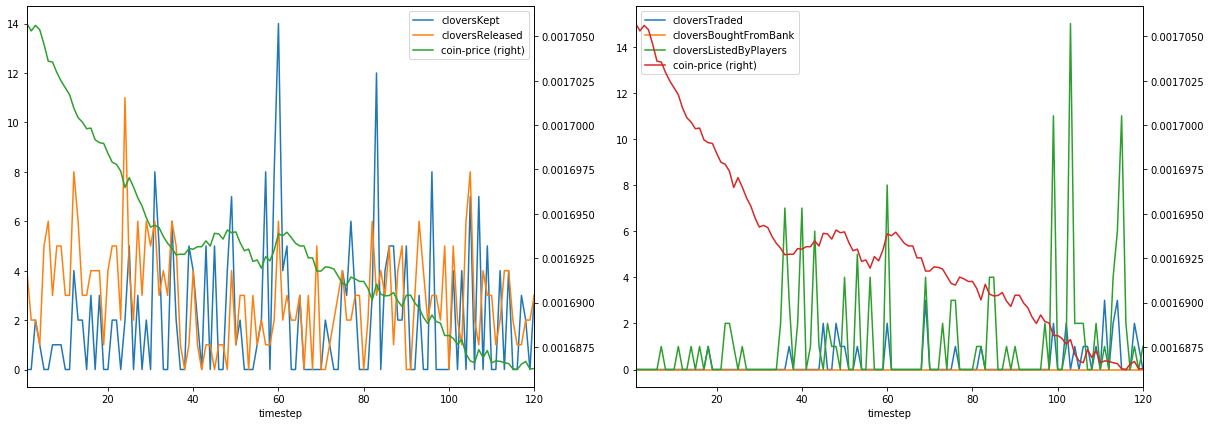

In [10]:
fig = plt.figure(figsize=(plt_width,plt_row_height*monte_carlo_runs))
axs = fig.subplots(monte_carlo_runs, 2)

if monte_carlo_runs == 1:
    df.plot('timestep', ['cloversKept', 'cloversReleased', 'coin-price'], secondary_y=['coin-price'], ax=axs[0])
    df.plot('timestep', ['cloversTraded','cloversBoughtFromBank', 'cloversListedByPlayers', 'coin-price'], secondary_y=['coin-price'], ax=axs[1])
else:
    for run in range(0,monte_carlo_runs):
        df.plot('timestep', ['cloversKept', 'cloversReleased', 'coin-price'], secondary_y=['coin-price'], ax=axs[run,0])
        df.plot('timestep', ['cloversTraded','cloversBoughtFromBank', 'cloversListedByPlayers', 'coin-price'], secondary_y=['coin-price'], ax=axs[run,1])

utils.savefig(fig, previousRuns, timesteps_per_run, 'hrs-price-graph')


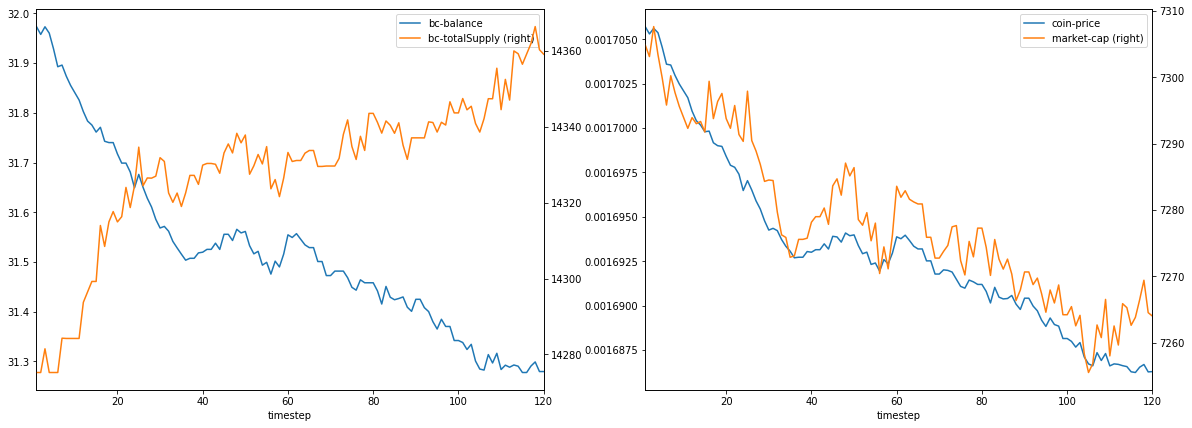

In [11]:
fig = plt.figure(figsize=(plt_width,plt_row_height*monte_carlo_runs))
axs = fig.subplots(monte_carlo_runs, 2)

if monte_carlo_runs == 1:
    df.plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[0])
    df.plot('timestep', ['coin-price', 'market-cap'], secondary_y=['market-cap'], ax=axs[1])
else:
    for run in range(0,monte_carlo_runs):
        df[df.run == (run+1)].plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[run,0])
        df[df.run == (run+1)].plot('timestep', ['coin-price', 'market-cap'], secondary_y=['market-cap'], ax=axs[run,1])

utils.savefig(fig, previousRuns, timesteps_per_run, 'hrs-price-graph')


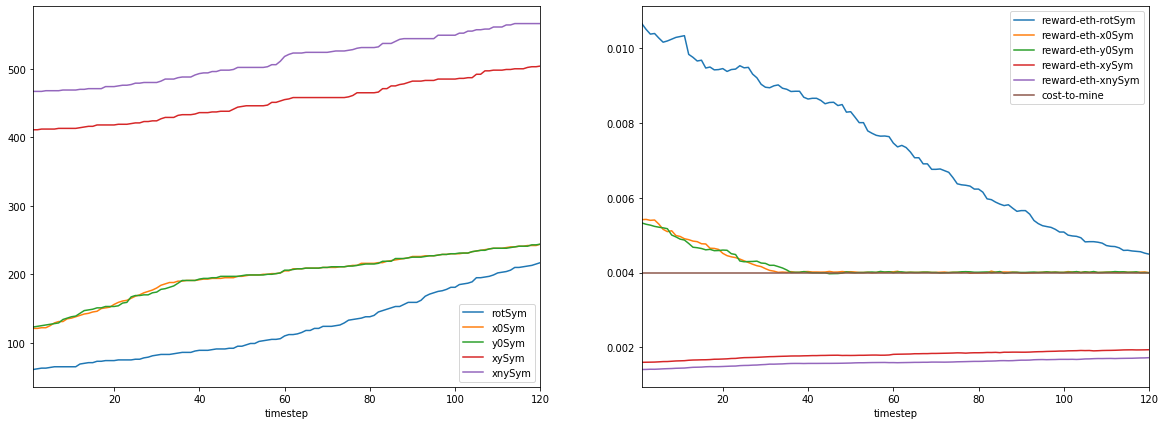

In [12]:
# set a figure with initial dimensions
fig = plt.figure(figsize=(plt_width,(plt_row_height*monte_carlo_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(monte_carlo_runs, 2)

if monte_carlo_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
            ax=axs[0]
           )
    
    df.plot('timestep', ['reward-eth-rotSym', 'reward-eth-x0Sym', 'reward-eth-y0Sym', 'reward-eth-xySym', 'reward-eth-xnySym', 'cost-to-mine'], ax=axs[1])

else:
    for row_idx in range(0,monte_carlo_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', 'bankClovers', ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
        df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])
utils.savefig(fig, previousRuns, timesteps_per_run, 'hrs-symms-graph')

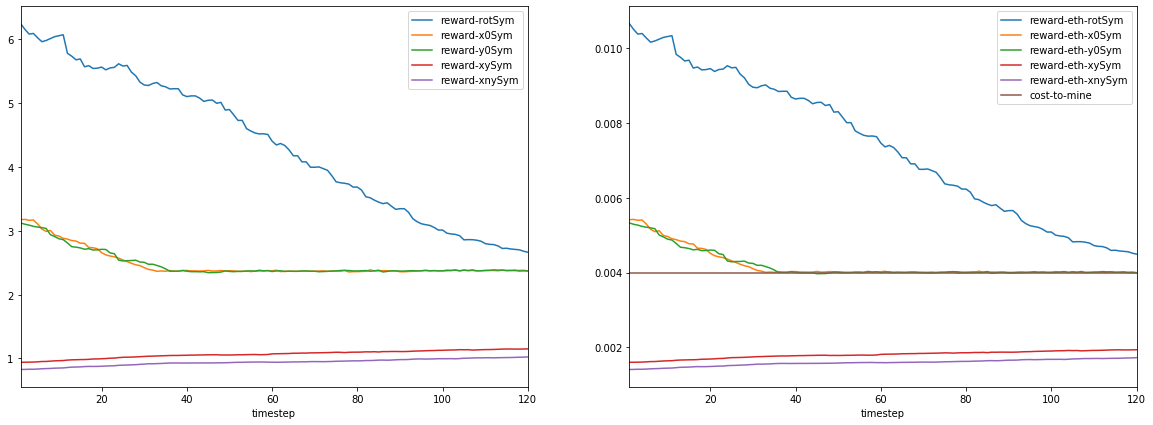

In [13]:
# set a figure with initial dimensions
fig = plt.figure(figsize=(plt_width,(plt_row_height*monte_carlo_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(monte_carlo_runs, 2)

if monte_carlo_runs == 1:
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
            ax=axs[0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df.plot('timestep', ['reward-eth-rotSym', 'reward-eth-x0Sym', 'reward-eth-y0Sym', 'reward-eth-xySym', 'reward-eth-xnySym', 'cost-to-mine'], ax=axs[1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
#     df.plot('timestep','bankClovers',secondary_y=True, ax=axs[1])
else:
    for row_idx in range(0,monte_carlo_runs):
        df_run = df[df.run == (row_idx + 1)]
        # draw out all the symmetries in a single graph, on ax1 (the left graph)
        df_run.plot('timestep', ['reward-rotSym', 'reward-x0Sym', 'reward-y0Sym', 'reward-xySym', 'reward-xnySym'], grid=False, 
                ax=axs[row_idx,0]
               )
        
        # draw out the bank clovers and total symms on ax2 (the right graph)
        df_run.plot('timestep', 'clovers', ax=axs[row_idx,1])
        
        # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
#         df_run.plot('timestep','bankClovers',secondary_y=True, ax=axs[row_idx,1])
utils.savefig(fig, previousRuns, timesteps_per_run, 'hrs-reward-graph')

In [17]:
params = results[0]['simulation_parameters']['M']

final_state = raw_result[-1]['s']
# g = final_state['network']
g = utils.getNetwork(params)
miners = utils.get_nodes_by_type(final_state, 'miner')
players = utils.get_nodes_by_type(final_state, 'player')

g.nodes[miners[0]]

cols_to_graph = ['eth-spent', 'eth-earned', 'supply']

fig = plt.figure(figsize=(plt_width,(plt_row_height*monte_carlo_runs)))
axs = fig.subplots(monte_carlo_runs, 2)

for row_idx in range(0,monte_carlo_runs):

    plot_data = [
        {
            "nodes": players,
            "title": "Final Balance (ETH & CLV) of Players",
            "x_label": "Player",
            "axis": (axs[0] if monte_carlo_runs == 1 else axs[row_idx,0])
        },
        {
            "nodes": miners,
            "title": "Final Balance (ETH & CLV) of Miners",
            "x_label": "Miner",
            "axis": (axs[1] if monte_carlo_runs == 1 else axs[row_idx,1])
        }
    ]
    
    for plot in plot_data:
        if (len(plot['nodes']) > 0):
            pdf = pd.DataFrame([g.nodes[player] for player in plot['nodes']])
            pdf[['eth-spent', 'eth-earned', 'supply']].plot(kind='bar', ax=plot['axis'], secondary_y='supply')
        plot['axis'].set(xlabel=plot['x_label'], ylabel='ETH', title=plot['title'])
        ax_2y = plot['axis'].twinx()
        ax_2y.set_ylabel("CloverCoin", labelpad=32)
        ax_2y.set_yticks([])
utils.savefig(fig, previousRuns, timesteps_per_run, 'hrs-eth-graph')

KeyError: 204889762303453

In [ ]:
# players = utils.get_nodes_by_type(raw_result[-1]['s'], 'player')
# affinities = np.empty((len(players), timesteps_per_run))
# # print("affinities", affinities)
# substeps = len(partial_state_update_blocks)
# for i_ind in range(len(players)):
#     nodeId = players[i_ind]
#     for j_ind in range(timesteps_per_run):
#         g = raw_result[j_ind*substeps]['s']['network']
#         # this line below sets the value to determine the color
#         # for a given player/timestep combination
#         # len(list(g.successors(i_ind))) => owned clovers by this user
#         if g.has_node(nodeId):
#             affinities[i_ind][j_ind] = len(list(g.successors(nodeId)))
#         else:
#             affinities[i_ind][j_ind] = 0

# dims = (20, 8)
# # adjust the dimensions

# fig, ax = plt.subplots(figsize=dims)

# sns.heatmap(affinities,
#             cbar=True, ax=ax)

# plt.title('Clovers owned by player, over time')
# plt.ylabel('Players')
# plt.xlabel('Timestep')
# utils.savefig(fig, previousRuns, timesteps_per_run, 'hrs-owners-graph')

In [ ]:
# states = [
#     {"payMultiplier": 0.20, "balance":17.016753, "totalSupply": 14291.312794, "clovers": 9225},
#     {"payMultiplier": 0.21, "balance":14.666017, "totalSupply": 14314.145592, "clovers": 10406},
#     {"payMultiplier": 0.22, "balance":12.515104, "totalSupply": 14327.019669, "clovers": 11401},
#     {"payMultiplier": 0.23, "balance":10.490474, "totalSupply": 14297.158162, "clovers": 12203},
#     {"payMultiplier": 0.24, "balance":8.686000, "totalSupply": 14310.146756, "clovers": 12790},
#     {"payMultiplier": 0.25, "balance":7.028548, "totalSupply": 14314.246525, "clovers": 13336},
#     {"payMultiplier": 0.26, "balance":5.492877, "totalSupply": 14323.500632, "clovers": 13837},
#     {"payMultiplier": 0.27, "balance":5.493877, "totalSupply": 14323.500632, "clovers": 13837},
#     {"payMultiplier": 0.28, "balance":2.726562, "totalSupply": 14323.155641, "clovers": 14343},
#     {"payMultiplier": 0.29, "balance":1.499142, "totalSupply": 14323.301790, "clovers": 14544},
#     {"payMultiplier": 0.30, "balance":0.355566, "totalSupply": 14323.477380, "clovers": 14675},
#     {"payMultiplier": 0.31, "balance":0.000700, "totalSupply": 14382.733430, "clovers": 14218},
#     {"payMultiplier": 0.32, "balance":0.008572, "totalSupply": 20620.749644, "clovers": 17451},
#     {"payMultiplier": 0.325, "balance":0.009267, "totalSupply": 21784.734994, "clovers": 17778},
#     {"payMultiplier": 0.326, "balance":0.005898, "totalSupply": 22876.389313, "clovers": 18401},
#     {"payMultiplier": 0.327, "balance":0.005898, "totalSupply": 22876.389313, "clovers": 18401},
#     {"payMultiplier": 0.33, "balance":0.000397, "totalSupply": 14338.616595, "clovers": 13370},
# ]

# fig = plt.figure(figsize=(16,5))
# axs = fig.subplots(1, 2)
# states = pd.DataFrame(states)
# # draw out all the symmetries in a single graph, on ax1 (the left graph)
# states.plot('payMultiplier', 'clovers', grid=False, ax=axs[0])
# states.plot('payMultiplier', ['balance', 'totalSupply'], secondary_y=['totalSupply'], grid=False, ax=axs[1])

    

In [ ]:
# players = utils.get_nodes_by_type(raw_result[-1]['s'], 'player')

# affinities = np.empty((len(players), timesteps_per_run))
# substeps = len(partial_state_update_blocks)

# for i_ind in range(len(players)):
#     playerId = players[i_ind]
#     for j_ind in range(timesteps_per_run):
#         g = raw_result[j_ind*substeps]['s']['network']
#         # this line below sets the value to determine the color
#         # for a given player/timestep combination
#         # len(list(g.successors(i_ind))) => owned clovers by this user
#         if g.has_node(playerId):
#             affinities[i_ind][j_ind] = g.nodes[playerId]['is_active']
#         else:
#             affinities[i_ind][j_ind] = False

# dims = (20, 5)

# fig, ax = plt.subplots(figsize=dims)

# sns.heatmap(affinities,
#             cbar=True, ax=ax)

# plt.title('Clovers owned by player, over time')
# plt.ylabel('Players')
# plt.xlabel('Timestep')
# utils.savefig(fig, previousRuns, timesteps_per_run, 'hrs-active-graph')

In [ ]:
# def test_function():
#     step = 1
#     s = raw_result[step]

#     _input = policies.miner_policy([params], step, None, s)
#     s['s'] = state_updates.update_state_miner_policy(None, step, None, s, _input)[1]

#     _input = policies.player_policy([params], step, None, s)
#     s['s'] = state_updates.update_state(None, step, None, s, _input)[1]
    
#     _input = policies.market_activity_policy([params], step, None, s)
#     s['s'] = state_updates.update_state(None, step, None, s, _input)[1]
#     return s
# # %lprun -f utils.processBuysAndSells test_function()
# %lprun \
# -f state_updates.update_state_miner_policy \
# -f state_updates.utils.saveNetwork \
# test_function()

In [ ]:
#import glob
#import sys
#from PIL import Image
#
#imageList = glob.glob("tmp/*.png")
#
#images = list(map(Image.open, imageList))
#widths, heights = zip(*(i.size for i in images))
#
#max_width = max(widths)
#total_height = sum(heights)
#
#new_im = Image.new('RGBA', (max_width, total_height))
#
#y_offset = 0
#for im in images:
#  new_im.paste(im, (0,y_offset))
#  y_offset += im.size[1]
#
#new_im.save('output.png')